# Fully Convolutional MNIST
This is to get a feel for building classifiers in TF

This model is fully convolutional, no fully connected layers

It works okay, but is really weird about more than 2 layer, sometimes it works, others it doesn't

As with any deepish NN, initialization is key. I did a blind manual search to find the values for the weight range and learning rate.

With incorrect hyper parameters, the model seems to 'forget' some of the possible outputs and simply never predicts them.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
%matplotlib inline
plt.rcParams['figure.figsize'] = (15,10)

# auto reloading of modules
%load_ext autoreload
%autoreload 2

# setup logging
tf.logging.set_verbosity(tf.logging.INFO)

In [2]:
# Settings
batch_size = 1000
epochs = 20 # number of epochs to train for
learning_rate = .01
momentum = .9
print_every = 25 # print info about training at iterations
test_every = 50 # number of iterations to go between doing 1 epoch of testing

reg = 0.01 # regularization strength

num_train = 60000 # 60000 max
num_test = 5000 # 10000 max

filter_depth = [10,10,10,10,10] # how many layers are in each convolution
filter_extent = [5,5,5,5,5] # how big the filters are on each layer
filter_stride = [1,1,1,1,1]
pool_use = False # use max pooling?
pool_stride = [2,2,2,2,2] # how big the stride is at every pool
pool_extent = [2,2,2,2,2] # how wide to max pool over
layer_padding = 'VALID'
checkpoint_file = 'models/MNIST_FCNN.ckpt'

img_shape = (28,28,1)

log_file = 'logs/' # where to save the tf log files

SEED = 0 # seed for random numbers

In [3]:
# these are updates/modifications/ utilites based on settings, do not change

# fixed seed for consistancy
np.random.seed(SEED)

# set up number of batches, make sure its a valid number
num_batches_train = num_train/batch_size
num_batches_test = num_test/batch_size
assert num_train%batch_size == 0, 'The number of training samples must be divisible by the batch size'
assert num_test%batch_size == 0, 'The number of test samples must be divisible by the batch size'

# determine how big the filter must be on the last layer to get a [nx1x10] vector
layer_width = float(img_shape[0])
counter = 0
for FE,FS,PS,PE in zip(filter_extent, filter_stride, pool_stride, pool_extent):
    counter += 1
    
    if layer_padding == 'VALID':
        print('In conv and VALID')
        layer_width = np.ceil(float(layer_width - FE + 1)/float(FS))
    elif layer_padding == 'SAME':
        print('In conv and SAME')
        layer_width = np.ceil(float(layer_width)/float(FS))
    else:
        print('\n\n--ERROR--\nInvalid padding scheme\n--ERROR--\n\n')
        break
    
    if pool_use:
        if layer_padding == 'VALID':
            print('In pooling and VALID')
            layer_width = np.ceil(float(layer_width - PE + 1)/float(PS))
        elif layer_padding == 'SAME':
            print('In pooling and SAME')
            layer_width = np.ceil(float(layer_width)/float(PS))
        else:
            print('\n\n--ERROR--\nInvalid padding scheme\n--ERROR--\n\n')
            break
        
    assert layer_width %int(layer_width) == 0, 'Current filter sizes, padding, stride, and pooling cause a non-integer output of layer {}'.format(counter)
    assert layer_width >= 1.0, 'Current filter sizes, padding, stride, and pooling cause a negative output of layer {}'.format(counter)
    print('After convolution {} and pooling, width is {}'.format(counter,layer_width))
print('Adding a {:.0f}x{:.0f} filter to remove spatial extents'.format(layer_width,layer_width))
filter_extent.append(layer_width)
filter_depth.append(10) # 10 outputs
filter_stride.append(1) # arbitrary, it can only do it once anyway

In conv and VALID
After convolution 1 and pooling, width is 24.0
In conv and VALID
After convolution 2 and pooling, width is 20.0
In conv and VALID
After convolution 3 and pooling, width is 16.0
In conv and VALID
After convolution 4 and pooling, width is 12.0
In conv and VALID
After convolution 5 and pooling, width is 8.0
Adding a 8x8 filter to remove spatial extents


## Using code from 3_mnist_from_scratch tutorial to deal with downloads and working with MNIST data

Took the code and made a simple module to make everything cleaner

In [4]:
import getMNIST
fNames = getMNIST.downloadMNIST()

train_data = getMNIST.extract_data(fNames[0],num_train)
test_data = getMNIST.extract_data(fNames[2],num_test)

train_labels = getMNIST.extract_labels(fNames[1], num_train)
test_labels = getMNIST.extract_labels(fNames[3], num_test)

('Already downloaded', 'train-images-idx3-ubyte.gz')
('Already downloaded', 'train-labels-idx1-ubyte.gz')
('Already downloaded', 't10k-images-idx3-ubyte.gz')
('Already downloaded', 't10k-labels-idx1-ubyte.gz')
('Extracting', '/tmp/mnist-data/train-images-idx3-ubyte.gz')
('Extracting', '/tmp/mnist-data/t10k-images-idx3-ubyte.gz')
('Extracting', '/tmp/mnist-data/train-labels-idx1-ubyte.gz')
('Extracting', '/tmp/mnist-data/t10k-labels-idx1-ubyte.gz')


## Building the model

In [5]:
# Set up inputs and outputs
X = tf.placeholder(tf.float32, shape = [batch_size,img_shape[0],img_shape[1],img_shape[2]],name='Input')
Y = tf.placeholder(tf.float32, shape = [batch_size,10],name = 'Labels') # 10 labels

In [6]:
conv_weights = {}
conv_bias = {}

prev_layer_depth = img_shape[2]
for layer in range(len(filter_depth)):
    layer_name = 'conv'+str(layer+1)
    
    filter_shape = [int(filter_extent[layer]),int(filter_extent[layer]), prev_layer_depth, int(filter_depth[layer])]
    
    
    # set up the scales for the weights
    # see https://www.tensorflow.org/versions/r0.11/api_docs/python/contrib.layers/initializers#xavier_initializer 
    # for more info, specifically varianc_scaling_initializer and http://arxiv.org/pdf/1502.01852v1.pdf
    fan_in = prev_layer_depth*filter_extent[layer]**2
    weight_scale = np.sqrt(2./fan_in)
    
    conv_weights[layer_name] = tf.Variable(tf.truncated_normal(filter_shape,
                                              stddev = weight_scale,
                                              seed = SEED),
                                          name = 'conv_weights_' + str(layer+1))
    
    conv_bias[layer_name] = tf.Variable(tf.zeros([int(filter_depth[layer])],dtype=tf.float32),
                                       name = 'conv_bias_' + str(layer+1))    
    
    prev_layer_depth = filter_depth[layer]
    
for layer in conv_weights:
    print('{}: {}'.format(layer, conv_weights[layer]))
    print('{}: {}'.format(layer, conv_bias[layer]))
    

conv3: <tf.Variable 'conv_weights_3:0' shape=(5, 5, 10, 10) dtype=float32_ref>
conv3: <tf.Variable 'conv_bias_3:0' shape=(10,) dtype=float32_ref>
conv2: <tf.Variable 'conv_weights_2:0' shape=(5, 5, 10, 10) dtype=float32_ref>
conv2: <tf.Variable 'conv_bias_2:0' shape=(10,) dtype=float32_ref>
conv1: <tf.Variable 'conv_weights_1:0' shape=(5, 5, 1, 10) dtype=float32_ref>
conv1: <tf.Variable 'conv_bias_1:0' shape=(10,) dtype=float32_ref>
conv6: <tf.Variable 'conv_weights_6:0' shape=(8, 8, 10, 10) dtype=float32_ref>
conv6: <tf.Variable 'conv_bias_6:0' shape=(10,) dtype=float32_ref>
conv5: <tf.Variable 'conv_weights_5:0' shape=(5, 5, 10, 10) dtype=float32_ref>
conv5: <tf.Variable 'conv_bias_5:0' shape=(10,) dtype=float32_ref>
conv4: <tf.Variable 'conv_weights_4:0' shape=(5, 5, 10, 10) dtype=float32_ref>
conv4: <tf.Variable 'conv_bias_4:0' shape=(10,) dtype=float32_ref>


In [7]:
fan_in

640.0

In [8]:
weight_scale

0.055901699437494741

In [9]:
# build the model
# dicts to store intermediate values

conv = {}
relu = {}
pool = {}
previous_layer = X

for layer in range(len(filter_depth)):
    layer_name = 'conv'+str(layer+1)
    print layer_name
    conv[layer_name] = tf.nn.conv2d(previous_layer,
                                   conv_weights[layer_name],
                                   strides=[1,filter_stride[layer],filter_stride[layer],1],
                                   padding='VALID',
                                   name = 'conv_' + str(layer+1))
    
    biased = tf.nn.bias_add(conv[layer_name], 
                            conv_bias[layer_name],
                            name = 'add_bias_' + str(layer+1))
    #apply relu
    relu[layer_name] = tf.nn.relu(biased,
                                  name = 'relu_' + str(layer+1))
    
    # check if doing pooling and if it is the last layer
    # no pooling on the last layer
    if pool_use and not layer == len(filter_depth)-1:
        print layer
        pool[layer_name] = tf.nn.max_pool(relu[layer_name],
                                         ksize=[1,2,2,1],
                                         strides = [1,2,2,1],
                                         padding = 'VALID',
                                         name = 'pool_' + str(layer+1))
        previous_layer = pool[layer_name]
    else: # not the last layer and not pooling 
        previous_layer = relu[layer_name]

    
loss = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(labels=Y,logits = previous_layer, name = 'softmax'),
                     name = 'loss')

# regularization loss
for ii in conv_weights:
    loss = tf.add(loss,reg * tf.nn.l2_loss(conv_weights[ii],
                                           name = 'Regularization_Loss_Addition'),
                      name = 'reg_loss_summing')
    
# get rid of singular dims in tensor
scores = tf.squeeze(previous_layer, name = 'prediction_squeeze')
predictions = tf.nn.softmax(logits = scores,
                           name = 'predictions_softmax')

num_correct = tf.reduce_sum(tf.cast(tf.equal(tf.argmax(predictions,1), tf.argmax(Y,1)),tf.float32),
                           name = 'num_correct')



conv1
conv2
conv3
conv4
conv5
conv6


In [10]:
weight_scale

0.055901699437494741

In [11]:
tf.trainable_variables()

[<tf.Variable 'conv_weights_1:0' shape=(5, 5, 1, 10) dtype=float32_ref>,
 <tf.Variable 'conv_bias_1:0' shape=(10,) dtype=float32_ref>,
 <tf.Variable 'conv_weights_2:0' shape=(5, 5, 10, 10) dtype=float32_ref>,
 <tf.Variable 'conv_bias_2:0' shape=(10,) dtype=float32_ref>,
 <tf.Variable 'conv_weights_3:0' shape=(5, 5, 10, 10) dtype=float32_ref>,
 <tf.Variable 'conv_bias_3:0' shape=(10,) dtype=float32_ref>,
 <tf.Variable 'conv_weights_4:0' shape=(5, 5, 10, 10) dtype=float32_ref>,
 <tf.Variable 'conv_bias_4:0' shape=(10,) dtype=float32_ref>,
 <tf.Variable 'conv_weights_5:0' shape=(5, 5, 10, 10) dtype=float32_ref>,
 <tf.Variable 'conv_bias_5:0' shape=(10,) dtype=float32_ref>,
 <tf.Variable 'conv_weights_6:0' shape=(8, 8, 10, 10) dtype=float32_ref>,
 <tf.Variable 'conv_bias_6:0' shape=(10,) dtype=float32_ref>]

In [12]:
optimizer = tf.train.MomentumOptimizer(learning_rate, momentum).minimize(loss)
init = tf.global_variables_initializer()

In [13]:
with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    
    batch = 0
    batch_start = batch*batch_size
    batch_end = batch_start + batch_size
    
    # run it
    out = sess.run(loss,
                   feed_dict={X:train_data[batch_start:batch_end,:],
                              Y:train_labels[batch_start:batch_end]})
    merged = tf.summary.merge_all()
    file_writer = tf.summary.FileWriter(log_file, sess.graph)
    

In [14]:
# loss history
losses_train = np.array([])
losses_test = np.array([])
# accuracy history
acc_train = np.array([])
acc_test = np.array([])

saver = tf.train.Saver()

iteration = -1 # counter
with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    
    for epoch in xrange(epochs):        
        for batch in xrange(num_batches_train):
            iteration += 1
            
            batch_start = batch*batch_size
            batch_end = batch_start + batch_size
            
            # We want different info based on the iteration. 
            # We dont actually need to compute everything on every iteration            
            if iteration % print_every == 0:
                solveFor = [optimizer, loss, predictions, num_correct]
            else:
                solveFor = [optimizer, loss]
            
            # run it
            out = sess.run(solveFor,
                           feed_dict={X:train_data[batch_start:batch_end,:],
                                      Y:train_labels[batch_start:batch_end]})
            
            if iteration % print_every == 0:
                _, l, pred, correct = out
                acc_train = np.append(acc_train, correct.astype(np.float32)/float(batch_size))
            else:
                _, l = out
                
            losses_train = np.append(losses_train,l)
            
            if iteration % print_every == 0:
                print('Iteration: {}/{}, batch {} on epoch {}, \tLoss: {:.2e}, Train Acc: {:.3f}'.format(iteration, 
                                                                                            epochs*num_batches_train,
                                                                                            batch, 
                                                                                            epoch, 
                                                                                            l, 
                                                                                            acc_train[-1]))
            
            if iteration % test_every == 0:
                l_test = 0
                correct_test = 0
                for test_it in xrange(num_batches_test):
                    batch_start = test_it*batch_size
                    batch_end = batch_start + batch_size
                    l, correct = sess.run([loss,num_correct],
                                         feed_dict={X:test_data[batch_start:batch_end,:],
                                                    Y:test_labels[batch_start:batch_end]})
                    correct_test += correct
                    l_test += l
                losses_test = np.append(losses_test,l_test.astype(np.float32)/float(num_batches_test))
                acc_test = np.append(acc_test, correct_test.astype(np.float32)/float(num_test))
                print('Testing Loss: {:.2e}\tTesting Accuracy: {:.3f}\n'.format(l_test, acc_test[-1]))
    save_path = saver.save(sess, checkpoint_file)
    print("Model saved in file: %s" % save_path)

Iteration: 0/1200, batch 0 on epoch 0, 	Loss: 2.79e+00, Train Acc: 0.072
Testing Loss: 1.40e+01	Testing Accuracy: 0.079

Iteration: 25/1200, batch 25 on epoch 0, 	Loss: 2.23e+00, Train Acc: 0.467
Iteration: 50/1200, batch 50 on epoch 0, 	Loss: 1.27e+00, Train Acc: 0.750
Testing Loss: 6.57e+00	Testing Accuracy: 0.744

Iteration: 75/1200, batch 15 on epoch 1, 	Loss: 9.99e-01, Train Acc: 0.826
Iteration: 100/1200, batch 40 on epoch 1, 	Loss: 6.71e-01, Train Acc: 0.927
Testing Loss: 3.84e+00	Testing Accuracy: 0.899

Iteration: 125/1200, batch 5 on epoch 2, 	Loss: 6.63e-01, Train Acc: 0.930
Iteration: 150/1200, batch 30 on epoch 2, 	Loss: 6.24e-01, Train Acc: 0.936
Testing Loss: 3.25e+00	Testing Accuracy: 0.925

Iteration: 175/1200, batch 55 on epoch 2, 	Loss: 5.38e-01, Train Acc: 0.963
Iteration: 200/1200, batch 20 on epoch 3, 	Loss: 5.67e-01, Train Acc: 0.945
Testing Loss: 2.84e+00	Testing Accuracy: 0.942

Iteration: 225/1200, batch 45 on epoch 3, 	Loss: 5.23e-01, Train Acc: 0.942
Iterati

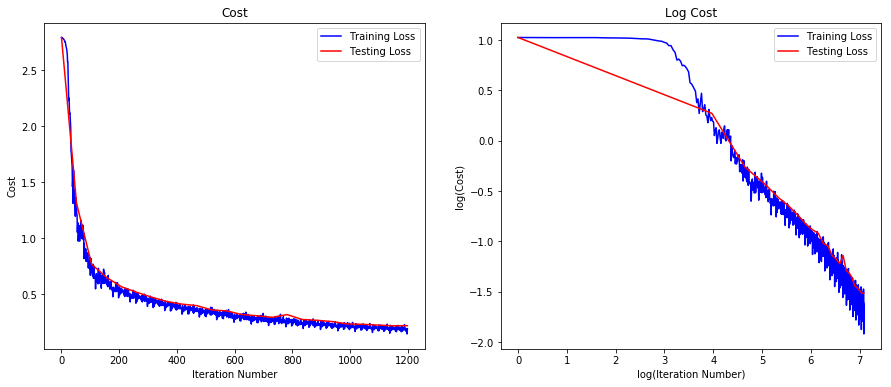

In [15]:
# Visualize the cost and log cost from training
plt.rcParams['figure.figsize'] = (15,6)

plt.subplot(121)
plt.plot(np.linspace(0,iteration,losses_train.shape[0]),losses_train,'b',label='Training Loss')
plt.plot(np.linspace(0,iteration,losses_test.shape[0]),losses_test,'r',label='Testing Loss')
plt.title('Cost')
plt.xlabel('Iteration Number')
plt.ylabel('Cost')
plt.legend()

plt.subplot(122)
plt.plot(np.log(np.linspace(1,iteration,losses_train.shape[0])),np.log(losses_train),'b',label='Training Loss')
plt.plot(np.log(np.linspace(1,iteration,losses_test.shape[0])),np.log(losses_test),'r',label='Testing Loss')
plt.title('Log Cost')
plt.xlabel('log(Iteration Number)')
plt.ylabel('log(Cost)')
plt.legend()

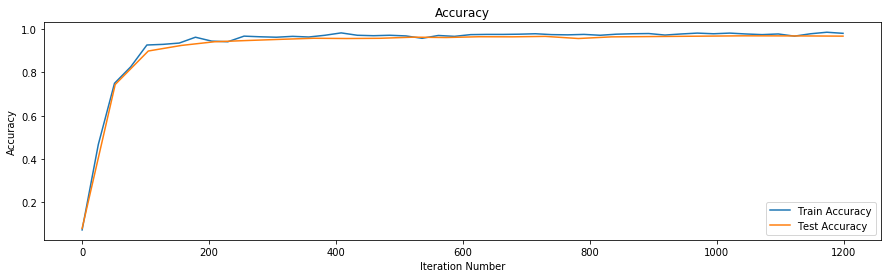

In [16]:
# See how the accuracy plays out between the test and training set
plt.rcParams['figure.figsize'] = (15,4)

plt.figure()
plt.plot(np.linspace(0,iteration,acc_train.shape[0]),acc_train,label = 'Train Accuracy')
plt.plot(np.linspace(0,iteration,acc_test.shape[0]),acc_test,label = 'Test Accuracy')
plt.title('Accuracy')
plt.xlabel('Iteration Number')
plt.ylabel('Accuracy')
plt.legend()


## Visualizing the model outputs
Want to see how the model did, specifically what is was confused on

In [17]:
# Generate predictions for the test and train set
saver = tf.train.Saver()

pred_train = np.zeros((num_train,10))
pred_test = np.zeros((num_test,10))


with tf.Session() as sess:
    # load the model from before
    saver.restore(sess, checkpoint_file)
    print('Finished loading the model')
    
    # batch over the entire training set and record predictions
    for it in xrange(num_batches_train):
        batch_start = it*batch_size
        batch_end = batch_start + batch_size
        pred_train[batch_start:batch_end,:] = sess.run(predictions,
                                                     feed_dict={X:train_data[batch_start:batch_end,:],
                                                                Y:train_labels[batch_start:batch_end]})
    print('Finished predictions for training data')
    
    # batch over the entire testing set and record predictions
    for it in xrange(num_batches_test):
        batch_start = it*batch_size
        batch_end = batch_start + batch_size
        pred_test[batch_start:batch_end,:] = sess.run(predictions,
                                                     feed_dict={X:test_data[batch_start:batch_end,:],
                                                                Y:test_labels[batch_start:batch_end]})
    print('Finished predictions for testing data')
print('Done!')

INFO:tensorflow:Restoring parameters from models/MNIST_FCNN.ckpt
Finished loading the model
Finished predictions for training data
Finished predictions for testing data
Done!


In [18]:
def error_rate(predictions, labels):
    """Return the error rate and confusions."""    
    actual = np.argmax(labels,1)
    pred = np.argmax(predictions,1)
    correct = np.sum(pred == actual)
    total = pred.shape[0]
    error = 100.0 - (100 * float(correct) / float(total))

    confusions = np.zeros([10, 10], np.float32)
    for ii in xrange(predictions.shape[0]):        
        confusions[pred[ii], actual[ii]] += 1
    
    return error, confusions

Train error: 2.2%


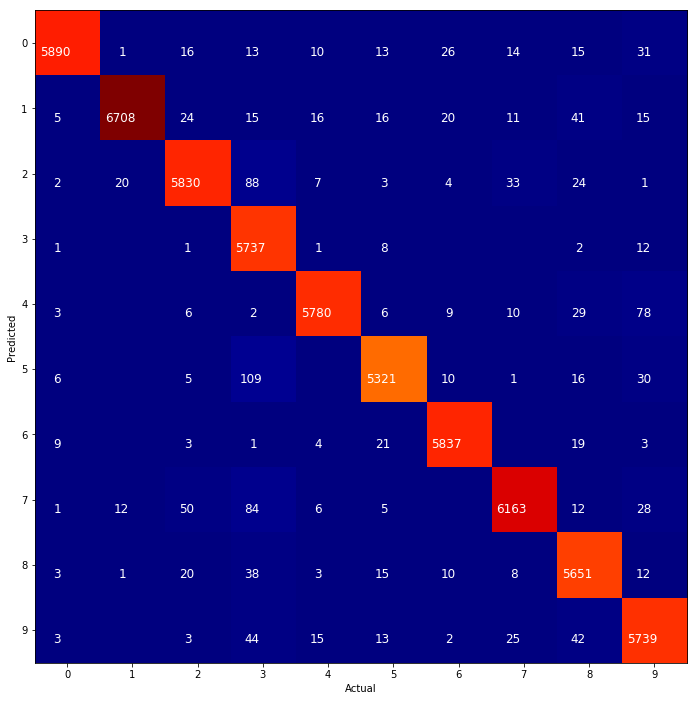

In [19]:
# Make confusion plot of the training set
plt.rcParams['figure.figsize'] = (20, 12)

error_train, confusions_train = error_rate(pred_train, train_labels)
print('Train error: %.1f%%' % error_train)

plt.xlabel('Actual')
plt.ylabel('Predicted')
plt.grid(False)
plt.xticks(np.arange(10))
plt.yticks(np.arange(10))
plt.imshow(confusions_train, cmap=plt.cm.jet, interpolation='nearest');

for i, cas in enumerate(confusions_train):
    for j, count in enumerate(cas):
        if count > 0:
            xoff = .07 * len(str(count))
            plt.text(j-xoff, i+.2, int(count), fontsize=12, color='white')

Test error: 3.0%


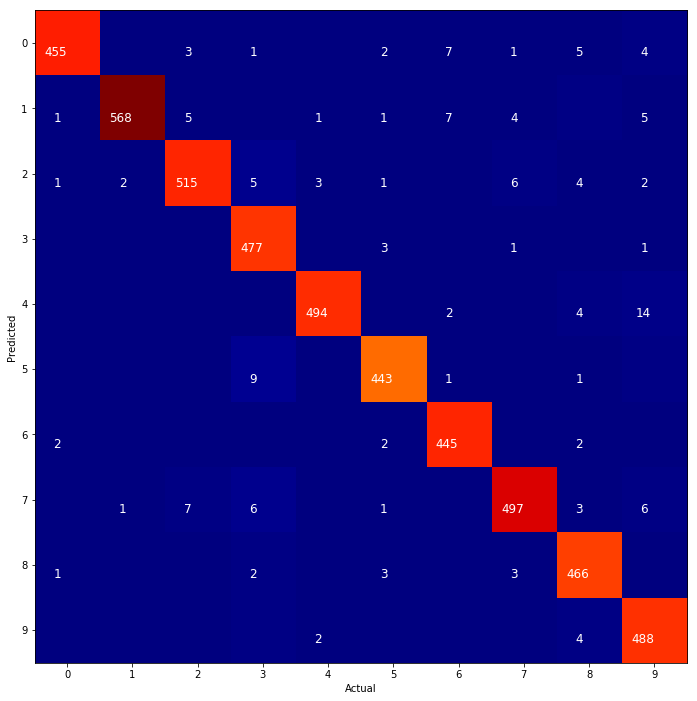

In [20]:
# Make confusion plot of the test set
plt.rcParams['figure.figsize'] = (20, 12)

error_test, confusions_test = error_rate(pred_test, test_labels)
print('Test error: %.1f%%' % error_test)

plt.xlabel('Actual')
plt.ylabel('Predicted')
plt.grid(False)
plt.xticks(np.arange(10))
plt.yticks(np.arange(10))
plt.imshow(confusions_train, cmap=plt.cm.jet, interpolation='nearest');

for i, cas in enumerate(confusions_test):
    for j, count in enumerate(cas):
        if count > 0:
            xoff = .07 * len(str(count))
            plt.text(j-xoff, i+.2, int(count), fontsize=12, color='white')